In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Embedding,
    Bidirectional,
    Dropout,
    GlobalMaxPooling1D,
    Concatenate,
    BatchNormalization,
    Conv1D,
    ReLU,
    Input,
    GRU,
    concatenate,
)
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.layers import Embedding, Flatten, Dense
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, pos_tag, ne_chunk
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime

In [ ]:
model = tf.keras.models.load_model(
    f"{os.getcwd()}/models/nlp_training_model_self.h5")

In [ ]:
df = pd.read_csv("datasets/regrets_dataset.csv", sep=";")
df["emotion"] = "regrets"
df2 = pd.read_csv("datasets/train.txt", sep=";")

df = pd.concat([df, df2], ignore_index=True)
df["emotion"].count()

In [ ]:
keys = df["emotion"].unique()
sample_arr = []

In [ ]:
train = None
for k in keys:
    sample = df[df["emotion"] == k].sample(241)
    sample_arr.append(sample)

train = pd.concat(sample_arr,axis=0)
train

In [ ]:
for layer in model.layers:
    if layer.name not in ["dense_9","input_23"]:
        layer.trainable = False

In [ ]:
for m in model.layers:
    print(m.trainable)
    
model.layers[0].trainable = True

In [ ]:
new_model = Sequential()


for idx, layer in enumerate(model.layers):
    if layer.name not in ["dense_9", "concatenate_3", "dense_8"]:
        new_model.add(layer)

dns = Dense(units=64, activation="relu")(new_model.layers[-1].output)
dns_1 = Dense(units=32, activation="relu")(dns)

outputs = tf.keras.layers.Dense(units=7, activation="softmax")(dns_1)

# input_layer_for_new_model = tf.keras.layers.Dense(
#     units=64, activation='softmax')(new_model.layers[-3].output)

new_model = tf.keras.Model(inputs=new_model.layers[0].input, outputs=outputs)
new_model.build(input_shape=(None, 50))
new_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
new_model.summary()

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower()
                     not in stop_words]
    return " ".join(filtered_text)


def stem_text(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)


def extract_entities(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    ne_chunks = ne_chunk(pos_tags)

    entities = []
    for chunk in ne_chunks:
        if hasattr(chunk, "label") and chunk.label():
            if chunk.label() == "NE":
                entities.append(" ".join([c[0] for c in chunk]))
    return entities


def create_tfidf_vectorizer(df):
    vectorizer = TfidfVectorizer(max_features=10000, use_idf=True)
    # Fit and transform the text data in the DataFrame column
    tfidf_matrix = vectorizer.fit_transform(df["sentence"])
    # Convert the TF-IDF matrix to a DataFrame for visualization
    return tfidf_matrix.toarray()


def tokenize_sentences(df):
    tr_text = df["sentence"]
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(tr_text)

    sequences = tokenizer.texts_to_sequences(tr_text)
    return sequences


def encode_emotions(emotions):
    encoder = LabelEncoder()
    return encoder.fit_transform(emotions)


def pad_sequences_with_zeros(X, maxlen):
    return pad_sequences(X, maxlen=maxlen)


def check_frequency_of_words(df):
    # Combine all sentences into one string
    all_sentences = " ".join(df["sentence"].tolist())

    # Tokenize the combined text into words
    words = all_sentences.split()

    # Create a Pandas Series to count word frequencies
    word_freq = pd.Series(words).value_counts()

    # Plot the top 20 most frequent words
    plt.figure(figsize=(10, 6))
    word_freq.head(20).plot(kind="bar", color="skyblue")
    plt.title("Top 20 Most Frequent Words in Sentences")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
etc = None
train["sentence"] = train["sentence"].apply(remove_stopwords)
# test["sentence"] = test["sentence"].apply(remove_stopwords)

train["sentence"] = train["sentence"].apply(stem_text)
# test["sentence"] = test["sentence"].apply(stem_text)
train["sentence"] = train["sentence"].str.replace(r'[^\w\s]', ' ', regex=True)
train["sentence"] = train["sentence"].str.replace(r'\s+', ' ', regex=True)

# train["entities"] = train["sentence"].apply(extract_entities)
# test["entities"] = test["sentence"].apply(extract_entities)
# val["entities"] = val["sentence"].apply(extract_entities)

train["sentence"] = train["sentence"].str.lower()
# test["sentence"] = test["sentence"].str.lower()

train_tfidf = tokenize_sentences(train)
# test_tfidf = tokenize_sentences(test)

train_padded = pad_sequences_with_zeros(train_tfidf, 50)
# test_padded = pad_sequences_with_zeros(test_tfidf, 50)

train["emotion_en"] = encode_emotions(train["emotion"])
# test["emotion_en"] = encode_emotions(test["emotion"])
# lets do lammentization next time

In [ ]:
train_padded.shape, train["emotion_en"].unique()

In [ ]:
y_train = to_categorical(train["emotion_en"])
y_train.shape

In [ ]:
new_model.fit(train_padded, y_train, epochs=50, batch_size=32, validation_split=0.2)

In [64]:
new_model.save("models/fine_tune_model_nlp_regrest.h5")

/Users/rusab1/Work/learntorch/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
input_sentence = ["i regret stuff i did in my teenages."]
df = pd.DataFrame(input_sentence, columns=['sentence'])

df["sentence"] = df["sentence"].apply(remove_stopwords)
df["sentence"] = df["sentence"].apply(stem_text)
df["sentence"] = df["sentence"].str.replace(r'[^\w\s]', ' ', regex=True)
df["sentence"] = df["sentence"].str.replace(r'\s+', ' ', regex=True)


print(df["sentence"])

input_ = tokenize_sentences(df)
input_ = pad_sequences_with_zeros(input_, 50)

#pred_val = model_old.predict([input_,input_]).argmax()
#result = emotion_en_decrypted.loc[emotion_en_decrypted['emotion_en'] == pred_val, 'emotion'].values[0]


pred_val_model = new_model.predict(input_).argmax()
result_model = emotion_en_decrypted.loc[emotion_en_decrypted['emotion_en'] == pred_val_model, 'emotion'].values[0]
#"old:",pred_val,result,
"|new:",pred_val_model,result_model

In [ ]:

# pred_val = model_old.predict([input_,input_]).argmax()
# result = emotion_en_decrypted.loc[emotion_en_decrypted['emotion_en'] == pred_val, 'emotion'].values[0]
predicted_label = []
val = pd.DataFrame()
val["sentence"] = train["sentence"].str.replace(r'[^\w\s]', ' ', regex=True)
val["sentence"] = train["sentence"].str.replace(r'\s+', ' ', regex=True)

inpt = tokenize_sentences(val)
inpt = pad_sequences_with_zeros(inpt, 50)

# for inpt_ in inpt:
pred_val_model = new_model.predict(inpt)
for preds in pred_val_model:
    result_model = emotion_en_decrypted.loc[emotion_en_decrypted["emotion_en"] == preds.argmax(), "emotion"].values[0]
    # "old:",pred_val,result,\
    predicted_label.append(result_model)

In [ ]:
emotion_en_decrypted = train[["emotion", "emotion_en"]]
emotion_en_decrypted = emotion_en_decrypted.drop_duplicates()

In [62]:
tst = train["emotion"]

Shape of Confusion Matrix: (7, 7)


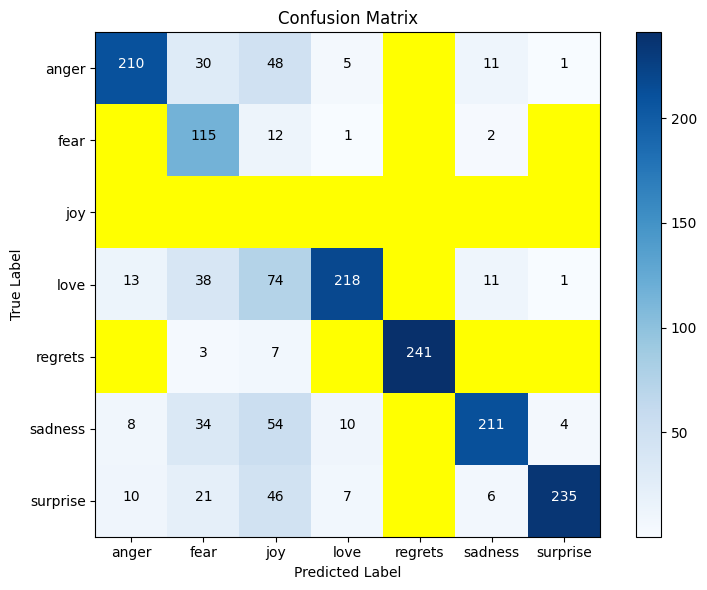

In [63]:
cm = confusion_matrix(predicted_label, tst)

# Identify misclassifications with counts greater than 1
misclassified_indices = np.where(cm > 0)

# Display the confusion matrix and its shape
# print("Confusion Matrix:")
# print(cm)
print("Shape of Confusion Matrix:", cm.shape)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))

# Define colors for the plot
cmap = plt.cm.Blues
# Set the color for misclassifications
#cmap.set_under('yellow')

plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.1)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding axis labels 
classes = np.unique(tst)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Adding annotations for misclassifications with counts > 1
thresh = cm.max() / 2.0
for i, j in zip(*misclassified_indices):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()